### This script uses different machine learning techniques to predict the failed hard drives at the Delta center in the Netherlands.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import seaborn
%matplotlib inline

## matplotlib settings
matplotlib.style.use('ggplot')
#plt.rcParams['figure.figsize']=16,10
plt.rcParams.update({'font.size': 12, 
                            'font.family': 'STIXGeneral', 
                            'mathtext.fontset': 'stix'})
# seaborn settings
seaborn.set_palette('deep', desat=.6)
np.random.seed(123456)
# machine learning packages 
import sklearn
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import metrics


<b style= "font-size: 120%;">
Dataset
</b>

In [2]:
# reading data set
data= pd.read_csv('hard_drive_data_2015.csv')
data= data.drop('Unnamed: 0', 1)
data= data.sort_values(by='date')

In [3]:
column_labels= np.array(['date','serial_number','model','capacity_bytes','failure',
                        'Read_error_rate_normalized', 'Read_error_rate_raw',
                        'spin-up_time_normalized', 'spin-up_time_raw', 
                        'Reallocated_sectors_counts_normalized','Reallocated_sectors_counts_raw', 
                        'Running_time_normalized','Running_time_raw', 
                        'Power_cycle_count_normalized','Power_cycle_count_raw', 
                        'Internal_temperature_normalized','Internal_temperature_raw'])
data.columns= column_labels

One way to look at the problem is by looking at the last properties of  working and failed disks; that is, without taking into account the temporal evolution.

In [4]:
fail= pd.DataFrame(data[data.failure==1]).reset_index()
fail= fail.drop('index', axis= 1)

In [5]:
success= data.groupby(['serial_number']).filter(lambda x: x['failure'].sum()==0) 
succ= pd.DataFrame(success.groupby(['serial_number']).tail(n=1)).reset_index()
succ= succ.drop('index', axis= 1)

In [6]:
data= pd.concat([fail, succ], ignore_index=True)

In [7]:
data.head(3)

,date,serial_number,model,capacity_bytes,failure,Read_error_rate_normalized,Read_error_rate_raw,spin-up_time_normalized,spin-up_time_raw,Reallocated_sectors_counts_normalized,Reallocated_sectors_counts_raw,Running_time_normalized,Running_time_raw,Power_cycle_count_normalized,Power_cycle_count_raw,Internal_temperature_normalized,Internal_temperature_raw
0,2015-01-01,JK11A8B9J7B38F,Hitachi HDS722020ALA330,2.000399e+12,1.0,99.0,65537.0,132.0,620.0,100.0,0.0,96.0,31965.0,100.0,12.0,206.0,29.0
1,2015-01-02,6XW063P4,ST31500541AS,1.500302e+12,1.0,110.0,25806111.0,100.0,0.0,3.0,3975.0,76.0,21494.0,100.0,40.0,26.0,26.0
2,2015-01-02,Z3012ABY,ST4000DM000,4.000787e+12,1.0,117.0,123702928.0,94.0,0.0,100.0,16.0,99.0,895.0,100.0,6.0,17.0,17.0


### Feature reduction

It is necessary to make a feature selection to generate more robust predictions (because it often increases classification accuracy by eliminating noise features). The feature selection is also ncessary to reduce the computational time when running a particulary expensive model. 

There are several tecniques to select features in a data set; however, In this analysis I will use Tree-based methods, because they can model non-linear relations between the target variable and the features. 

In [8]:
data= data.drop(['date','serial_number', 'model'], axis=1)

In [9]:
data.head(3)

,capacity_bytes,failure,Read_error_rate_normalized,Read_error_rate_raw,spin-up_time_normalized,spin-up_time_raw,Reallocated_sectors_counts_normalized,Reallocated_sectors_counts_raw,Running_time_normalized,Running_time_raw,Power_cycle_count_normalized,Power_cycle_count_raw,Internal_temperature_normalized,Internal_temperature_raw
0,2.000399e+12,1.0,99.0,65537.0,132.0,620.0,100.0,0.0,96.0,31965.0,100.0,12.0,206.0,29.0
1,1.500302e+12,1.0,110.0,25806111.0,100.0,0.0,3.0,3975.0,76.0,21494.0,100.0,40.0,26.0,26.0
2,4.000787e+12,1.0,117.0,123702928.0,94.0,0.0,100.0,16.0,99.0,895.0,100.0,6.0,17.0,17.0


In [10]:
def plot_features(feat, std, index, columns):
    
        num_cols= len(columns) # total columns in the dataframe
       
        plt.figure(figsize= (6,6))
        plt.barh(range(num_cols), feat[index], 
                 color="r", xerr=std[index], align="center")
        #plt.xticks(range(X.shape[1]), indices)
        #plt.xlim([-1, X.shape[1]])
        plt.xlim(0, 1.2*max(feat))
        plt.yticks(range(num_cols), columns[index])
        plt.xlabel("Feature importance", fontsize=20)
        plt.savefig('feature_selection_with_tree.pdf', bbox_inches= 'tight')
        plt.show()
            

        # write these results in the final report
        print("Feature ranking:")
        for f in range(num_cols):
            print("feature %d (%f)"%(index[f], feat[index[f]]))

In [11]:
def select_features_with_tree(df, estimators= 100):
    '''
    Input: dataset
    output: X, y with reduced features
    '''
    X= df.drop('failure', axis= 1) # removing target variable from dataset
    y= df.failure.copy()
    
    cols= X.columns
    ncols= len(cols)
    
    forest = ExtraTreesClassifier(n_estimators= estimators, random_state=0, 
                                 max_depth= 10, min_samples_leaf=5)
    forest.fit(X,y)
    features= forest.feature_importances_
    # each estimator has a feature importance
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
    # order of importance
    indices = np.argsort(features)[::-1] 
    
    # reduce df to the most important features
    model= SelectFromModel(forest, prefit=True)
    columns= [j for i, j in enumerate(cols)  if (model.get_support()[i]== True)]
    X_redu= pd.DataFrame(model.transform(X), columns= columns)
    y_redu= y
    
    plot_features(features, std, indices, cols)
    
    return X_redu, y_redu

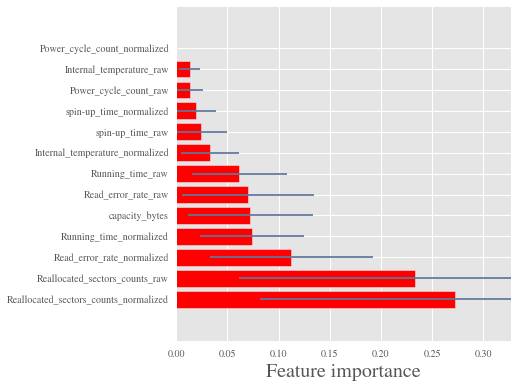

Feature ranking:
feature 5 (0.272355)
feature 6 (0.233044)
feature 1 (0.112491)
feature 7 (0.073909)
feature 0 (0.072422)
feature 2 (0.070425)
feature 8 (0.061731)
feature 11 (0.033361)
feature 4 (0.024020)
feature 3 (0.019501)
feature 10 (0.013420)
feature 12 (0.013321)
feature 9 (0.000000)


In [12]:
X_reduced, y_reduced= select_features_with_tree(data, estimators= 100)

### Select a train and test sets

In [13]:
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(
    X_reduced, y_reduced, test_size=0.3, random_state = 5)
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape) 

(44029, 3)
(18870, 3)
(44029,)
(18870,)


## Fraction of failed and working disks: 
### (Unbalanced sample)

In [14]:
y_train.index= X_train.index
unbalanced_set= pd.concat([X_train, y_train], axis=1)

In [15]:
sd= np.shape(unbalanced_set.ix[unbalanced_set.failure==0])[0]
fd= np.shape(unbalanced_set.ix[unbalanced_set.failure==1])[0]
tot= sd+fd
print ('Fraction of failed disks:', fd/tot, '%')
print ('Fraction of working disks:', sd/tot, '%')

Fraction of failed disks: 0.022825864770946423 %
Fraction of working disks: 0.9771741352290536 %


<p style= "font-size: 120%;">
Clearly this is an unbalanced classification problem. This is solved by: <br> 
1. Oversampling the minority class. <br>
2. Undersampling the majority class. 
</p>

<b style= "font-size: 140%;">
a. Oversampling:
</b>

The oversampling is done such that the percentages of the failed and working disks in the new sample will be 40% and 60% respectively.

In [16]:
def get_oversampled_set(df, target_variable= 'failure', frac_minority= 0.4, frac_mayority=0.6):
    minority_class= df.ix[df[target_variable]== 1]
    mayority_class= df.ix[df[target_variable]== 0]
    num_elements= (frac_minority/frac_mayority)*np.shape(mayority_class)[0]
    minority_class= minority_class.sample(n=int(num_elements), replace=True, random_state= 123456)
    new_sample= pd.concat([minority_class, mayority_class])
    
    maj= mayority_class.shape[0] 
    print ('Fraction of failed disks after oversampling:', num_elements/(num_elements+maj) )
    print ('Fraction of working disks after oversampling:', maj/(num_elements+maj) )
    return new_sample
    

In [17]:
oversampled_set= get_oversampled_set(unbalanced_set)

Fraction of failed disks after oversampling: 0.4
Fraction of working disks after oversampling: 0.6


In [18]:
X_oversampled= oversampled_set.drop('failure', axis=1)
y_oversampled= oversampled_set.failure.copy()

###  a1. Building the prediction model
To be consistent with the procedure carried out to make a feature selection, I will use a random forest classifier on the balanced set to predict the disks that fail.

In [19]:
model = RandomForestClassifier(n_estimators=200, 
                               oob_score=True, 
                               min_samples_leaf=5, 
                               max_depth=10)


In [20]:
model.fit(X_oversampled, y_oversampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [21]:
prediction= model.predict(X_test)

In [22]:
pred_probabilities = model.predict_proba(X_test)

### How good the model is?

### Area under the curve (AUC) and ROC curves

In [23]:
AUC= metrics.roc_auc_score(y_test, pred_probabilities[:,1])

In [24]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_probabilities[:,1])

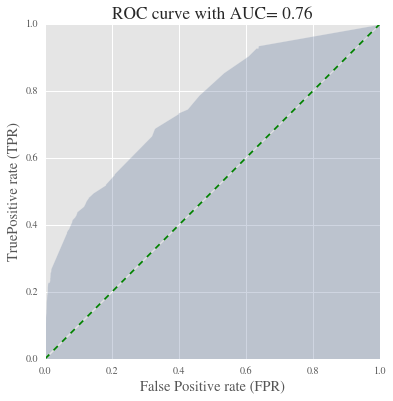

In [25]:
fig= plt.figure(figsize=(6,6))
ax= fig.add_subplot(111)
ax.fill(fpr, tpr, alpha= 0.3)
ax.fill_between(np.linspace(0,1, 10), np.linspace(0,1,10), alpha= 0.3)
ax.plot([0,1], [0,1], 'g--' )
ax.set_title('ROC curve with AUC= %.2f'%AUC)
ax.set_xlabel('False Positive rate (FPR)')
ax.set_ylabel('TruePositive rate (TPR)');
plt.savefig('ROC_oversampling.pdf', bbox_inches='tight')

### Precision and Recall

In [26]:
precision = metrics.precision_score(y_test, prediction)
recall = metrics.recall_score(y_test, prediction)
print ('True positive rate:', recall)
print ('False positive rate:', precision)

True positive rate: 0.41134751773
False positive rate: 0.103818615752


In [54]:
metrics.confusion_matrix(y_test, prediction)

array([[16945,  1502],
       [  249,   174]])

In [55]:
print ('failed disks:', np.shape(y_test[y_test==1]) )
print ('working disks:', np.shape(y_test[y_test==0]) )

failed disks: (423,)
working disks: (18447,)


<b style= "font-size: 140%;">
b. Subsampling:
</b>


In [27]:
def get_subsampled_set(df, target_variable= 'failure', frac_minority= 0.4, frac_mayority=0.6):
    minority_class= df.ix[df[target_variable]== 1]
    mayority_class= df.ix[df[target_variable]== 0]
    num_elements= (frac_mayority/frac_minority)*np.shape(minority_class)[0]
    mayority_class= mayority_class.sample(n=int(num_elements), random_state= 123456)
    new_sample= pd.concat([minority_class, mayority_class])
    
    minu= minority_class.shape[0] 
    print ('Fraction of failed disks after subsampling:', minu/(num_elements+minu) )
    print ('Fraction of working disks after subsampling:', num_elements/(num_elements+minu) )
    return new_sample

In [28]:
subsampled_set= get_subsampled_set(unbalanced_set)

Fraction of failed disks after subsampling: 0.4
Fraction of working disks after subsampling: 0.5999999999999999


In [29]:
X_subsampled= subsampled_set.drop('failure', axis=1)
y_subsampled= subsampled_set.failure.copy()

###  b1. Building the prediction model

In [30]:
model1 = RandomForestClassifier(n_estimators=200, 
                               oob_score=True, 
                               min_samples_leaf=5, 
                               max_depth=10)

In [31]:
model1.fit(X_subsampled, y_subsampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [32]:
prediction1= model1.predict(X_test)

In [33]:
pred_probabilities1 = model1.predict_proba(X_test)

### How good the model is?

### Area under the curve (AUC) and ROC curves

In [34]:
AUC1= metrics.roc_auc_score(y_test, pred_probabilities1[:,1])

In [35]:
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, pred_probabilities1[:,1])

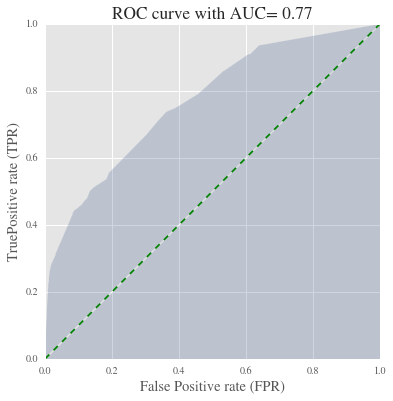

In [36]:
fig= plt.figure(figsize=(6,6))
ax= fig.add_subplot(111)
ax.fill(fpr1, tpr1, alpha= 0.3)
ax.fill_between(np.linspace(0,1, 10), np.linspace(0,1,10), alpha= 0.3)
ax.plot([0,1], [0,1], 'g--' )
ax.set_title('ROC curve with AUC= %.2f'%AUC1)
ax.set_xlabel('False Positive rate (FPR)')
ax.set_ylabel('TruePositive rate (TPR)');
plt.savefig('ROC_subsampling.pdf', bbox_inches='tight')

### Precision and Recall

In [37]:
precision1 = metrics.precision_score(y_test, prediction1)
recall1 = metrics.recall_score(y_test, prediction1)
print ('True positive rate:', recall1)
print ('False positive rate:', precision1)

True positive rate: 0.437352245863
False positive rate: 0.106998264893


<b style= "font-size: 140%;">
c. Subsampling with Bootstrap aggregating (bagging):
</b>



In [38]:
def get_subsampled_bootstrap(df, target_variable= 'failure'):
    rand= int(34456*np.random.rand())
    df= df.sample(n= df.shape[0], replace=True, 
                  random_state= rand )
    
    minority_class= df.ix[df[target_variable]== 1]
    minority_elements= minority_class.shape[0]
    mayority_class= df.ix[df[target_variable]== 0]
    mayority_class= mayority_class.sample(minority_elements)
    new_sample= pd.concat([minority_class, mayority_class])
    return new_sample

In [39]:
def bagging(df, x_test, y_test, n_iter= 100):
    # generate boostraped and balanced subsamples of df
    model_list=[]
    for i in range(1, n_iter+1):
        subsample= get_subsampled_bootstrap(df)
        X_subsampled= subsampled_set.drop('failure', axis=1)
        y_subsampled= subsampled_set.failure.copy()
        tree = DecisionTreeClassifier(max_depth=10,
                                       min_samples_leaf=5)
        tree.fit(X_subsampled, y_subsampled)
        model_list.append(tree)
        
    # make a prediction for n_iter models
    predictions= pd.DataFrame()
    pred_proba= pd.DataFrame()
    for i, model in enumerate(model_list):
        prediction= model.predict(x_test)
        col= 'prediction_'+str(i)
        predictions[col]= prediction
        
        pred_prob= model.predict_proba(x_test)
        proba_df= pd.DataFrame(pred_prob)
        col= 'prediction_proba_'+str(i)
        pred_proba[col]= proba_df[1]
        
    # aggregate the results
    predictions['avg']= predictions.mean(axis=1)
    predictions['final_prediction']= predictions.mode(axis=1)[0]
    predictions['actual_value']= y_test.values
    
    pred_proba['avg']= pred_proba.mean(axis=1)
    
    return predictions, pred_proba

In [40]:
predictions, probabilities = bagging(unbalanced_set, X_test, y_test)

### Area under the curve (AUC) and ROC curves

In [41]:
#AUC_bagg= metrics.roc_auc_score(predictions.actual_value, predictions.avg)
AUC_bagg= metrics.roc_auc_score(predictions.actual_value, 
                               probabilities.avg)
AUC_bagg

0.76553985534688163

In [42]:
fprb, tprb, thresholdsb = metrics.roc_curve(predictions.actual_value,
                                            probabilities.avg)

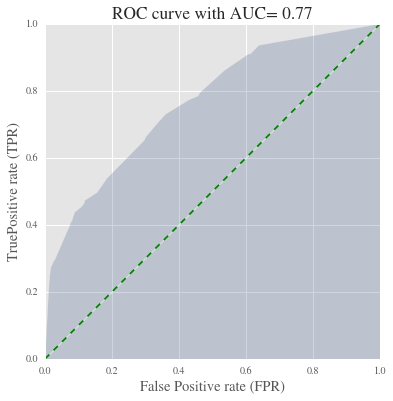

In [43]:
fig= plt.figure(figsize=(6,6))
ax= fig.add_subplot(111)
ax.fill(fprb, tprb, alpha= 0.3)
ax.fill_between(np.linspace(0,1, 10), np.linspace(0,1,10), alpha= 0.3)
ax.plot([0,1], [0,1], 'g--' )
ax.set_title('ROC curve with AUC= %.2f'%AUC_bagg)
ax.set_xlabel('False Positive rate (FPR)')
ax.set_ylabel('TruePositive rate (TPR)');
plt.savefig('ROC_bagging.pdf', bbox_inches='tight')

### Precision and Recall

In [44]:
precisionb = metrics.precision_score(predictions.actual_value, 
                                     predictions.final_prediction)
recallb = metrics.recall_score(predictions.actual_value, 
                               predictions.final_prediction)
print ('True positive rate:', recallb)
print ('False positive rate:', precisionb)

True positive rate: 0.430260047281
False positive rate: 0.102477477477


## Predictions of failed disks for the first week of 2016

In [45]:
week= pd.read_csv('hard_drive_data_2016.csv')

In [46]:
week_X= week[X_reduced.columns]

In [47]:
week_y= week.failure

In [48]:
np.shape(week_X), np.shape(week_y)

((402741, 3), (402741,))

In [49]:
week_y_pred= model1.predict(week_X)

In [50]:
week_pred_proba = model1.predict_proba(week_X)

In [51]:
prec1 = metrics.precision_score(week_y, week_y_pred)
rec1 = metrics.recall_score(week_y, week_y_pred)
print ('True positive rate:', rec1)
print ('False positive rate:', prec1)

True positive rate: 0.4
False positive rate: 0.000458190148912
